# Meta
This notebook is an introduction to the data we'll use during the workshop, and gives you some hands-on experience in analysing text data.

In the following, we've sprinkled in "challenges" which you're more than welcome to engage in. 

We've tried to split them up into "execution" (which require writing code) and "reflection" (which are about the conceptual knowledge and potential use in your organisation). 

Try your best to keep the group active and focus on reflecting on the concepts and potential applications. Understanding the code is important, but secondary.

# Exploratory analyses
Typically when working with text, you're given a scrape of some source. These scrapes are never as clean as you'd like them to be.

For example, we were given a scrape of au.dk which included everything: menu items, contact information, you name it. When doing content analysis, we're typically only interested in the content.

We've tried to remove menus etc. by running a deduplication script which removes identical "sentences". 

But did we do well? 
Or did we remove all the frequent elements (e.g. every mention of Aarhus University?)

Your challenge is to get some quick, basic estimates of whether our deduplication was meaningful, and in which cases the dataset can be used. 

Let's take a look!

First, we load the packages that we'll be using and one of the datasets.

# Load data

In [1]:
from pathlib import Path
import os
data_dir = Path(os.path.abspath("")).parent / "795173" / "deduped"
data_path = data_dir / "au.dk_deduped.ndjson"

print(data_path)

/work/795173/deduped/au.dk_deduped.ndjson


# Inspecting the data
A surprisingly good way to figure out whether text-processing has been succesful is to, well, read it. Let's start by looking at an example.

In [2]:
import pandas as pd
df = pd.read_json(data_path, lines=True)

In [3]:
df

,url,text
0,https://au.dk/nyheder/browse/204,Samarbejde med forskere Samarbejde med studere...
1,https://au.dk/nyheder/browse/301,Samarbejde med forskere Samarbejde med studere...
2,https://au.dk/nyheder/artikel/ny-erkendelse-me...,Ny erkendelse medførte ændret estimat af kvæls...
3,https://au.dk/evu/generel-information,Samarbejde med forskere Samarbejde med studere...
4,https://au.dk/subuniversity/for-gymnasieelever...,Samarbejde med forskere Samarbejde med studere...
...,...,...
2168,https://au.dk/auchallenge/contact,Samarbejde med forskere Samarbejde med studere...
2169,https://au.dk/en/informationsecurity/annualpla...,Step 3: CHECK: Follow up Information Security ...
2170,https://au.dk/om/organisation/regelsamling/4/4...,Samarbejde med forskere Samarbejde med studere...
2171,https://au.dk/nyheder/artikel/skoldkoppevirus-...,Skoldkoppevirus livsfarlig ved nyopdaget immun...


In [4]:
df["text"][10]

"Tre yngre forskere på Aarhus Universitet får ERC-bevillinger fra Det Europæiske Forskningsråd Aarhus Universitets logo Til studerende Til ph.d.er Til medarbejdere Institutter og fakulteter Bibliotek Presse Brightspace MITSTUDIE.AU.DK Fælles sider for ph.d.-studerende phd.au.dk Ph.d.-portaler Fælles sider for medarbejdere på AU medarbejdere.au.dk Medarbejderportaler Find den lokale medarbejderportal for dit institut eller område. Samarbejde med forskere Samarbejde med studerende Gymnasier Gymnasieportalen Det rullende universitet Myndigheder Myndighedsrådgivning Samarbejde Om AU Organisation Fakulteter Institutter Centre Ledelse Administration Organisationsdiagram Kontakt Bygningskort Kontaktoplysninger Telefon, e-mail og adresser for alle ansatte Whistleblowerordning Profil Strategi AU i tal Internationalt samarbejde Bæredygtighed Campus 2.0 Job Ledige stillinger på AU Job- og projektbank for studerende og nyuddannede Om AU Du er her: AU Nyheder Tre yngre forskere på Aarhus Universite

The second half looks pretty good, but there's still some headers present!

### Challenge 
**Execution:**
* We've only shown you one example of a webpage. Do the others look any good?

<details>
<summary>Hints</summary>
Try changing the 10 in `df["text"][10]`
</details>

# Aggregate analysis
Now, there are

In [5]:
len(df)

2173

2173 webpages to look at, and since our time is valuable, looking at them all doesn't make much sense. 

Instead, we can use some proxies to find webpages that look especially suspicious. For example, ones with extremely short or extremely long content. 

Let's take a stab at that.

<Axes: >

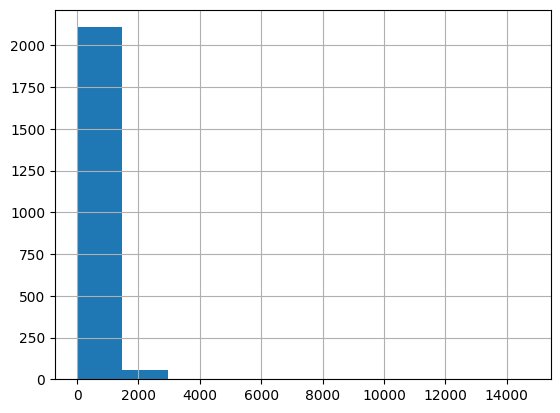

In [6]:
webp_lengths = df["text"].str.split().map(lambda x: len(x))
webp_lengths.hist()

In [7]:
webp_lengths.describe()

count     2173.000000
mean       515.223654
std        616.275809
min         12.000000
25%        204.000000
50%        378.000000
75%        662.000000
max      14699.000000
Name: text, dtype: float64

Huh, looks like we have some outliers which are very long web pages. Let's have a look at all the ones below the 95th percentile.

In [8]:
percentile_95 = webp_lengths.quantile(0.95)
webp_lengths_filtered = webp_lengths[webp_lengths < percentile_95]

<Axes: >

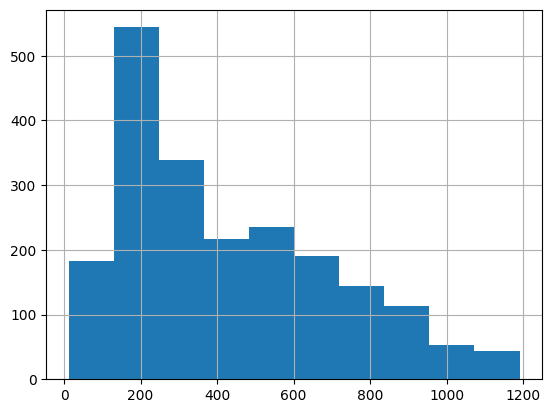

In [9]:
webp_lengths_filtered.hist()

That looks more reasonable. We could drop all the long web-pages as outliers, but that could be problematic for some of our further analyses.

### Challenge:
**Execution:**
* Look at the longest texts. What are they? 

<details>
<summary>Hints</summary></br>
Get the value for the 99th percentile of webpage length. </br>
</br> Filter based on that value like in <pre>webp_lengths[webp_lengths < percentile_95]</pre>
</details>

**Reflection:**
* Why are the web pages so long?
* Should we include them in further analyses?

# Word-level analysis
Since we're worried we might have removed frequent, but important bits of text, we can look at words as well.

For example, "au" should occur extremely frequently, but we do not want our deduplication script to remove it if it is part of the main content. We only want it to remove template-like sentences such as "AU logo here". 

Let's see if the most frequent words match our expectations.

In [10]:
# Most frequent words
webpages_split = df["text"].str.split().values.tolist()

word_counts = {}

for split_webpage in webpages_split:
    for word in split_webpage:
        word_lowered = word.lower()
        if word_lowered not in word_counts:
            word_counts[word_lowered] = 1
        else:
            word_counts[word_lowered] += 1

word_counts


{'samarbejde': 8118,
 'med': 13084,
 'forskere': 3069,
 'studerende': 5389,
 'gymnasier': 1736,
 'gymnasieportalen': 1743,
 'det': 11480,
 'rullende': 1744,
 'universitet': 6103,
 'myndigheder': 1742,
 'myndighedsrådgivning': 1666,
 'om': 9909,
 'au': 12911,
 'organisation': 2115,
 'fakulteter': 2879,
 'institutter': 2830,
 'centre': 1926,
 'ledelse': 2025,
 'administration': 1814,
 'organisationsdiagram': 1635,
 'kontakt': 3116,
 'bygningskort': 1639,
 'kontaktoplysninger': 1673,
 'telefon,': 1641,
 'e-mail': 1653,
 'og': 35805,
 'adresser': 1636,
 'for': 21698,
 'alle': 2779,
 'ansatte': 1732,
 'whistleblowerordning': 1641,
 'profil': 2375,
 'strategi': 1998,
 'i': 23595,
 'tal': 1933,
 'internationalt': 2078,
 'bæredygtighed': 1911,
 'campus': 2150,
 '2.0': 1967,
 'job': 1728,
 'ledige': 2626,
 'stillinger': 2573,
 'på': 16158,
 'job-': 1644,
 'projektbank': 1638,
 'nyuddannede': 1653,
 'du': 4783,
 'er': 15113,
 'her:': 1734,
 'nyheder': 1751,
 'marsvin': 9,
 'kommunikerer': 15,
 '

In [11]:
word_counts_df = pd.DataFrame({"word": word_counts.keys(), "counts": word_counts.values()})
word_counts_df.sort_values("counts", ascending=False)

,word,counts
25,og,35805
33,i,23595
27,for,21698
54,at,17329
42,på,16158
...,...,...
81356,infektionen.,1
81357,vzv-infektion.,1
81358,"immundefekten,",1
81359,defekten.,1


Well, not very interesting that "og", "i", "for", "at" etc. are frequent on a Danish webpage! 

Fortunately, this is a well known problem in NLP, and we can remove these "stop words".

In [12]:
from spacy.lang.da.stop_words import STOP_WORDS
danish_stop_words = STOP_WORDS
print(danish_stop_words)

from spacy.lang.en.stop_words import STOP_WORDS
english_stop_words = STOP_WORDS
print(english_stop_words)

STOP_WORDS = danish_stop_words.union(english_stop_words)
print(STOP_WORDS)

{'man', 'ny', 'at', 'hvornår', 'allerede', 'hvilken', 'mere', 'gørende', 'mindre', 'andre', 'nogle', 'altid', 'nær', 'bag', 'derefter', 'næsten', 'over', 'uden', 'vore', 'hvordan', 'således', 'de', 'lidt', 'nemlig', 'alene', 'hvis', 'henover', 'fra', 'heri', 'da', 'hvad', 'hvorfor', 'ind', 'til', 'ligesom', 'igennem', 'måske', 'min', 'syntes', 'dens', 'gjorde', 'dermed', 'hvor', 'flere', 'hendes', 'sådan', 'langs', 'hvorfra', 'dine', 'du', 'ville', 'omkring', 'dig', 'en', 'flest', 'ham', 'næste', 'nyt', 'stadig', 'hvorimod', 'burde', 'hvorefter', 'lav', 'har', 'må', 'op', 'sig', 'jer', 'været', 'meget', 'han', 'deres', 'enhver', 'hvilke', 'nogen', 'din', 'end', 'få', 'før', 'senere', 'selvom', 'udover', 'intet', 'med', 'tidligere', 'bliver', 'fleste', 'ned', 'anden', 'der', 'via', 'det', 'enten', 'så', 'blive', 'indtil', 'herpå', 'som', 'først', 'lavet', 'ene', 'nu', 'vil', 'egen', 'hvilkes', 'imellem', 'mange', 'alt', 'mellem', 'eller', 'efter', 'og', 'heller', 'den', 'for', 'ved', 'h

Let's remove them!

In [13]:
non_stop_word_counts = word_counts_df[~word_counts_df["word"].isin(STOP_WORDS)].sort_values(by="counts", ascending=False)
non_stop_word_counts

,word,counts
12,au,12911
90,aarhus,10476
0,samarbejde,8118
60,-,7436
8,universitet,6103
...,...,...
81333,evaluation?,1
81334,intended?,1
81335,adequate?,1
81336,compromised,1


That's more like it! Let's take a look at the top 50.

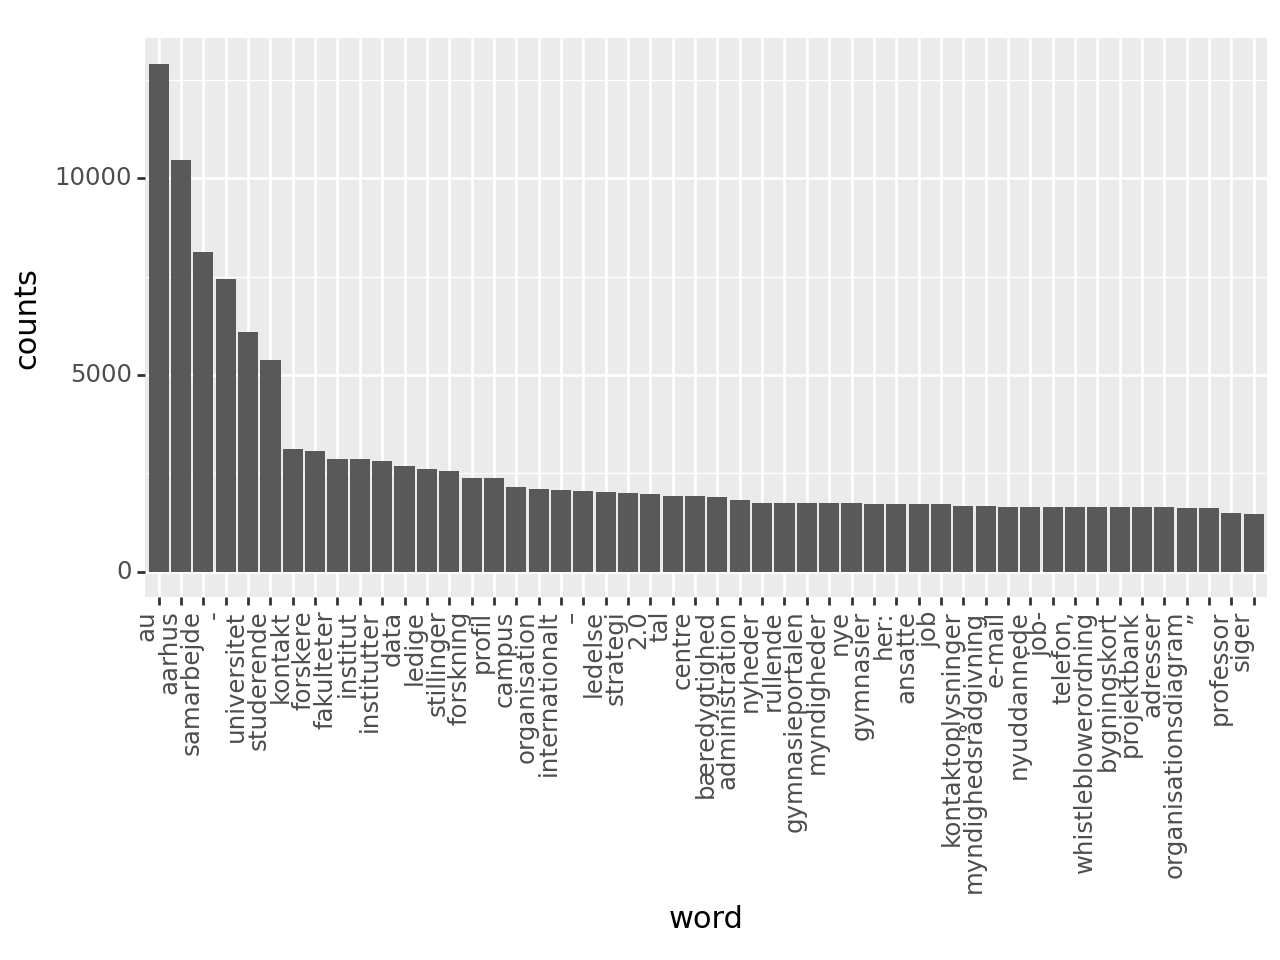

<Figure Size: (640 x 480)>

In [14]:
import plotnine as pn

# Create some categories so the x-axis on our bar-plot is sorted by count instead of alphabetically
word_names = non_stop_word_counts["word"]
non_stop_word_counts["word"] = pd.Categorical(non_stop_word_counts["word"], categories=word_names)

(pn.ggplot(non_stop_word_counts.head(50), pn.aes(x="word", y="counts")) + 
    pn.geom_bar(stat="identity") + 
    pn.theme(axis_text_x=pn.element_text(rotation=90, hjust=1)))

### Larger challenge:
**Reflection**:
* How else would you check if deduplication was succesful?
* Are there other interesting analyses you could do?
    * E.g. at https://au.dk/nyheder/browse/[i], where i is an integer larger than 0, you can get all the news from the AU blog. 
       * Could you check whether changes in "AU strategy" are reflected in which blog posts are created?
       * Keep this in mind as we add more complicated analyses later on
       
**Execution**:
* There are other datasets in the `data_dir`. Any of those you want to look at?